In [ ]:
from IPython.display import clear_output

!pip install -U "ray[rllib]"
!pip install tianshou
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install mat4py

clear_output()

# LIBPackEnv

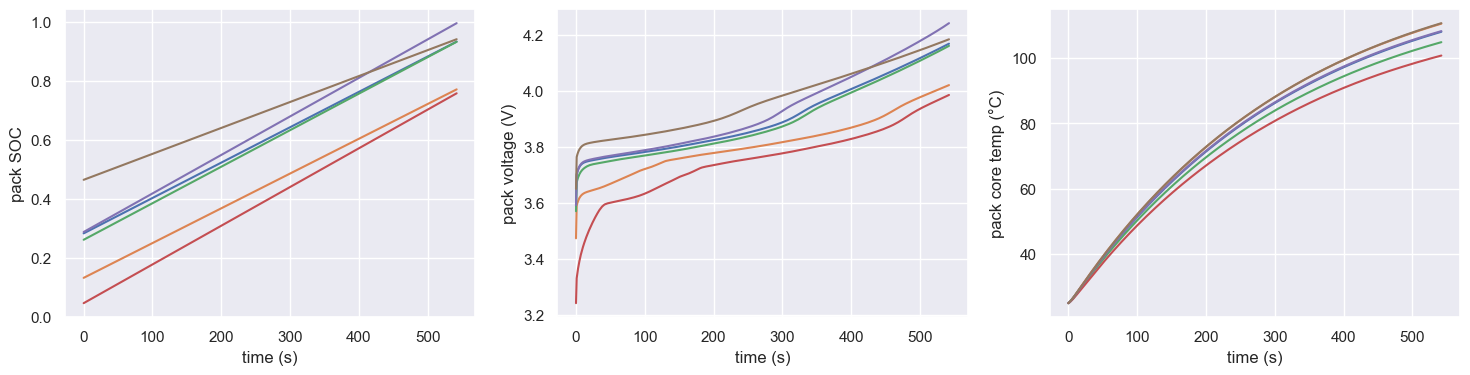

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym import LIBPackEnv
import seaborn as sns
sns.set_theme()

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1, use_switch=False)

pack_res=[]
rewards = []
pack_res.append(env.reset(0)[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:]*(env.max_voltage-env.min_voltage)+env.min_voltage)
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:]*env.T)
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

# Ray

In [2]:
import ray

ray.init(local_mode=False, ignore_reinit_error=True)

2023-07-28 20:06:28,742	INFO worker.py:1621 -- Started a local Ray instance.


Python version:,3.10.9
Ray version:,2.6.1


In [3]:
from ray.tune.registry import register_env

select_env = "LIBPackEnv"
chkpt_root ='./'
register_env(select_env, lambda config: LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1))

In [11]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.sac import SACConfig

agent = (
    SACConfig()
    .training(gamma=0.99, lr=0.001)
    # .rollouts(num_rollout_workers=4)
    .resources(num_gpus=1)
    .environment(env=select_env)
    .build()
)

output_dir= "ray_models"
best_reward = -float("inf")
best_checkpoint = None
RETURNS = []
LENGTHS = []

n_episodes = 1000
current_episode = 0
total_episodes = 0

for i in range(n_episodes):
    
    while total_episodes == current_episode:
        result = agent.train()
        total_episodes = result["episodes_total"]
    current_episode = total_episodes
    
    reward = result["episode_reward_mean"]
    length = result["episode_len_mean"]
    RETURNS.append(reward)
    LENGTHS.append(length)
    if reward > best_reward:
        best_reward = reward
        best_checkpoint = agent.save(os.path.join(output_dir, "_best"))
    checkpoint = agent.save(os.path.join(output_dir, "_checkpoint"))
    print(f"Episode {i}: R: {reward:.2f}, L: {length:.2f}, C: {checkpoint} || Best R: {best_reward:.2f}, best C: {best_checkpoint}")

d:\Users\amirh\anaconda3\lib\site-packages\ray\rllib\algorithms\algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
d:\Users\amirh\anaconda3\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
d:\Users\amirh\anaconda3\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You cou

Episode 0: R: -5489.38, L: 1476.00, C: ray_models\_checkpoint\checkpoint_000010 || Best R: -5489.38, best C: ray_models\_best\checkpoint_000010
Episode 1: R: -4736.57, L: 1365.00, C: ray_models\_checkpoint\checkpoint_000023 || Best R: -4736.57, best C: ray_models\_best\checkpoint_000023
Episode 2: R: -4942.73, L: 1322.67, C: ray_models\_checkpoint\checkpoint_000035 || Best R: -4736.57, best C: ray_models\_best\checkpoint_000023
Episode 3: R: -5024.77, L: 1267.00, C: ray_models\_checkpoint\checkpoint_000046 || Best R: -4736.57, best C: ray_models\_best\checkpoint_000023
Episode 4: R: -5253.56, L: 1320.20, C: ray_models\_checkpoint\checkpoint_000061 || Best R: -4736.57, best C: ray_models\_best\checkpoint_000023
Episode 5: R: -5198.33, L: 1335.83, C: ray_models\_checkpoint\checkpoint_000076 || Best R: -4736.57, best C: ray_models\_best\checkpoint_000023
Episode 6: R: -5113.94, L: 1323.71, C: ray_models\_checkpoint\checkpoint_000088 || Best R: -4736.57, best C: ray_models\_best\checkpoint

KeyboardInterrupt: 

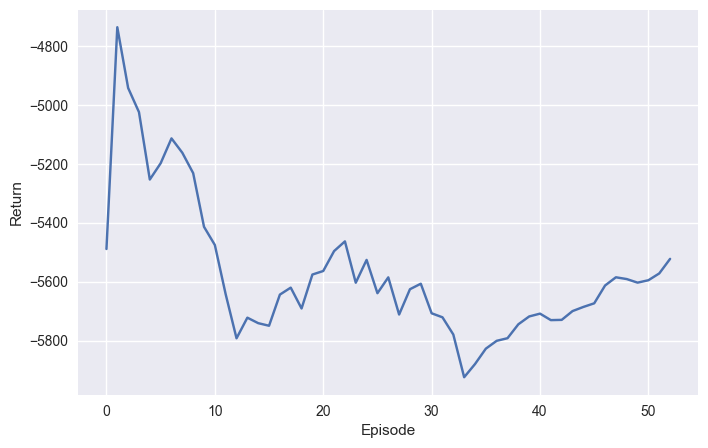

In [12]:
import pandas as pd
returns = np.array(RETURNS).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid('on')

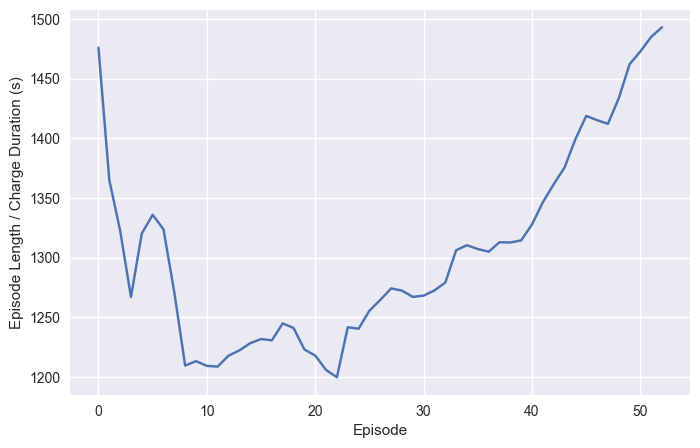

In [13]:
import pandas as pd
returns = np.array(LENGTHS).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Episode Length / Charge Duration (s)')
plt.grid('on')

In [ ]:
# !tensorboard --logdir=$HOME/ray_results

^C


### Evaluation

2023-07-28 23:45:47,478	INFO trainable.py:904 -- Restored on 127.0.0.1 from checkpoint: ray_models\_checkpoint\checkpoint_000787
2023-07-28 23:45:47,483	INFO trainable.py:913 -- Current state after restoring: {'_iteration': 787, '_timesteps_total': None, '_time_total': 12751.906467199326, '_episodes_total': 53}


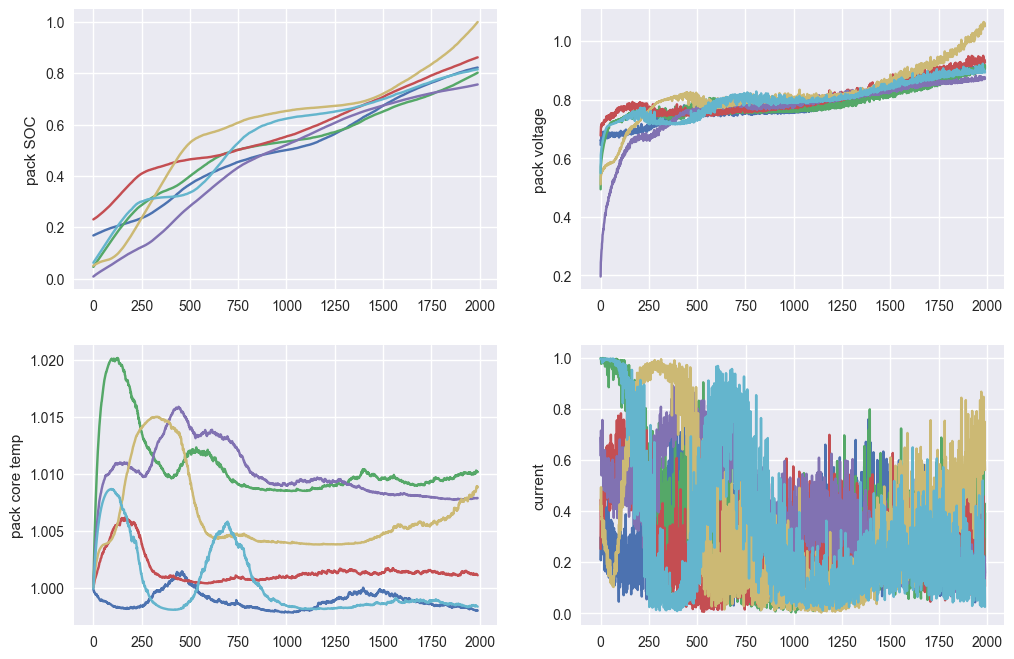

In [15]:
agent.restore(checkpoint)

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)
state, _ = env.reset()

pack_res=[]
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    action = agent.compute_single_action(state)
    next_state, reward, done, _, info = env.step(action)
    state = next_state
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:-1].reshape(-1,6))
plt.ylabel('current')
plt.grid('on')